# Postprocessing

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
from matplotlib.pyplot import *
from math import sqrt
from scipy import integrate

from dns_channel.tke import read_uiuj as uiuj
from dns_channel.tke import ebox
import dns_channel as ch
import dnsdb as db

---
## User settings

In [2]:
sim_name = 'poi_retau_100'
sim_directory = './/' # directory (relative to this notebook) where .dat are stored
db_directory = '/user/hi209/Runs/dns_database.json' # directory of dns database
problem = 'poi' # specify problem for ebox calculation

convT = 400 # time at which convergence is reached

---

## Actual postprocessing

In [3]:
# load files
runtime, me, uv, uu, vv, ww, kk, mk = uiuj.read(sim_directory)
dnsin = ch.read_dnsin(sim_directory)

In [4]:
# preallocate dictionaries
simdict = {}
simdict['power_units'] = {}
simdict['meta'] = {}
simdict['meta']['problem'] = problem

In [5]:
# get Reynolds number
simdict['re'] = dnsin['re']

temp_series = runtime['t'] # time from runtimedata
idx = temp_series[temp_series >= convT].index[0] # index at which t_convergence is reached

# get kinematic Reynolds number
if problem == 'cou':
    simdict['rew'] = simdict['re'] * abs(me['U'].iat[0] - me['U'].iat[-1])/2
    rek = simdict['rew']
elif problem == 'poi':
    temp_ub_arr = runtime['Ub']/2 # Ub provided by runtimedata is actually flow rate; hence divide by two
    temp_ub_arr = temp_ub_arr.loc[idx:]
    ub = temp_ub_arr.mean()
    simdict['reb'] = simdict['re'] * abs(ub)
    rek = simdict['reb']

## Accurate calculation of $\tau_w$

<IPython.core.display.Javascript object>


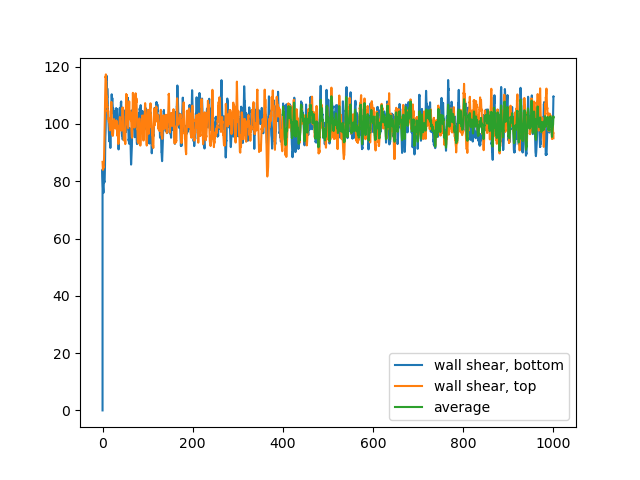

In [6]:
# plot time story of velocity gradient at the wall
fig, ax = subplots()
ax.plot(runtime['t'], abs(runtime['Uy_bottom']))
ax.plot(runtime['t'], abs(runtime['Uy_top']))
legend(['wall shear, bottom', 'wall shear, top'])

In [7]:
# calculate and plot average
temp_tw_arr = (abs(runtime['Uy_bottom']) + abs(runtime['Uy_top']))/2
temp_tw_arr = temp_tw_arr.loc[idx:]
plot(temp_series[temp_series >= convT], temp_tw_arr) # check that you cut the array correctly
legend(['wall shear, bottom', 'wall shear, top', 'average'])

In [8]:
# calculate friction Reynolds number
tauw = temp_tw_arr.mean() / simdict['re']
utau = tauw**(1/2)
simdict['retau'] = simdict['re'] * utau
print('Friction Reynolds number: {}'.format(simdict['retau']))

Friction Reynolds number: 100.05406014035285


## Calculation of power and $Re_\pi$
In nondimensional terms:

$$\Pi = \tau_w U_w = \tau_w$$

$$U_\pi = \sqrt{Re \, \Pi}$$

$$Re_\pi = Re\, U_\pi $$ 

In [9]:
# calculate power Reynolds number
simdict['repi'] = (simdict['retau']**2 * rek)**(1/3)
print('Power Reynolds number: {}'.format(simdict['repi']))

Power Reynolds number: 244.88863114285687


## Mesh details, dns.in, cutoff wavelength

In [10]:
# get mesh info
mesh = ch.mesh(dnsin)

# get time used for average
simdict['meta']['t_avg_mixedunits'] = uiuj.get_nfield(sim_directory) * dnsin['dt_field'] * utau

# add mesh info to dictionary
simdict['meta']['nx'] = mesh.nx
simdict['meta']['ny'] = mesh.ny
simdict['meta']['nz'] = mesh.nz
simdict['meta']['lx_pih'] = mesh.lx_pih
simdict['meta']['lz_pih'] = mesh.lz_pih

# add mesh resolution in viscous units to dictionary
simdict['meta']['dx_plus']  = mesh.dx  * simdict['retau']
simdict['meta']['dz_plus']  = mesh.dz  * simdict['retau']
simdict['meta']['dyw_plus'] = mesh.dyw * simdict['retau']
simdict['meta']['dyc_plus'] = mesh.dyc * simdict['retau']

In [11]:
nkz_ts = uiuj.get_z_threshold(sim_directory) # get index of threshold wavenumber
kz_ts = nkz_ts * mesh.beta0 # threshold wavenumber
lzth_pih = 2/kz_ts # threshold wavelength divided by pi and h
simdict['meta']['threshold_lambda_z_pih'] = lzth_pih # save threshold wavelength

## Energy box

In [12]:
# get ebox metadata
rephi, alpha, beta = ebox.properties(sim_directory, convT, problem)
simdict['rephi'] = rephi
simdict['power_units']['alpha'] = alpha
simdict['power_units']['beta'] = beta

In [13]:
# get extended ebox
phil, pl_s, pl_l, pd_s, pd_l, t_cross, eps_s, eps_l, phid = ebox.tennis(sim_directory, convT, problem)

# check residuals
print('Ebox - residuals check')
print('----------------------')
print('Laminar: ', 1 - phil - pl_s - pl_l) # laminar
print('Small scale: ', pl_s + pd_s - t_cross - eps_s) # small
print('Large scale: ', pl_l + pd_l + t_cross - eps_l) # large
print('Deviation: ', - pd_l - pd_s - phid) # deviation

Ebox - residuals check
----------------------
Laminar:  -0.001167067233637617
Small scale:  0.0005721491304739312
Large scale:  0.0005398193904663368
Deviation:  0.0010582192469174856


In [14]:
# save ebox to dictionary

simdict['power_units']['phil'] = phil

simdict['power_units']['pl_s'] = pl_s
simdict['power_units']['pl_l'] = pl_l
simdict['power_units']['pl'] = pl_s + pl_l

simdict['power_units']['pd_s'] = pd_s
simdict['power_units']['pd_l'] = pd_l
simdict['power_units']['pd'] = pd_s + pd_l

simdict['power_units']['t_cross'] = t_cross

simdict['power_units']['eps_s'] = eps_s
simdict['power_units']['eps_l'] = eps_l
simdict['power_units']['eps'] = eps_s + eps_l

simdict['power_units']['phid'] = phid

## Save data

In [15]:
# dump data
db.save(simdict, db_directory, sim=sim_name)

# Verification: total stress $\tau$ in viscous units

<IPython.core.display.Javascript object>


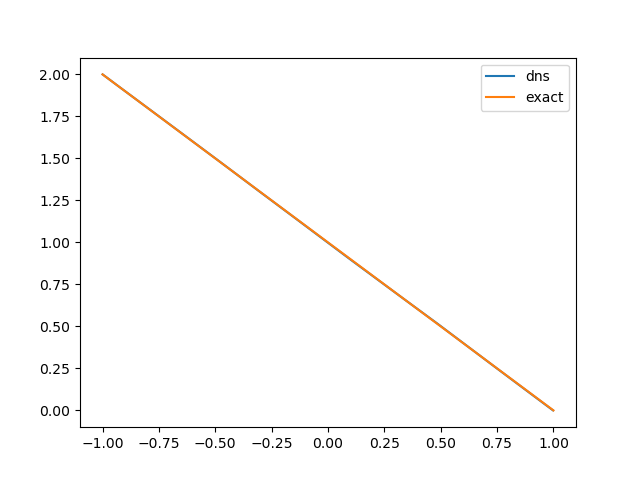

In [16]:
tauT = me['Uy']/simdict['re'] - uv['var']
tauT /= tauw
fig, ax = subplots()
plot(tauT, me['y'])
exact = lambda y : 1 - y
plot(exact(me['y'].values), me['y'].values)
ax.legend(['dns', 'exact'])

<IPython.core.display.Javascript object>


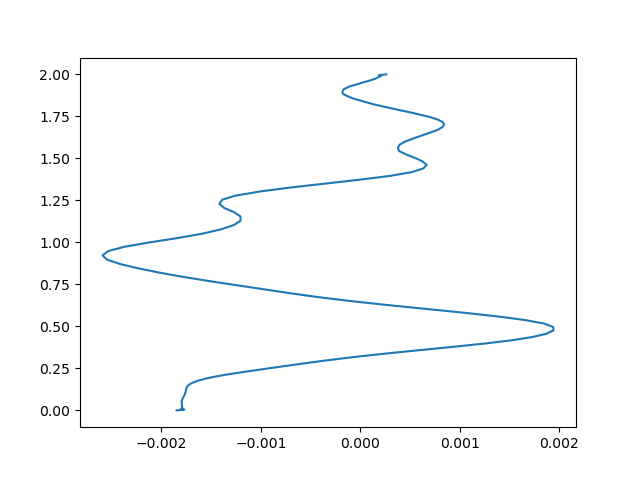

Residual check
--------------
RMS error on total shear equation:  0.0011581305036874943


In [17]:
errTauT = tauT - exact(me['y'].values)
fig, ax = subplots()
plot(errTauT, me['y'])

print('Residual check')
print('--------------')
print('RMS error on total shear equation: ', errTauT.std())